<h1><font color='blue'>YELP RESTAURANT RECOMMENDATION ENGINE</font></h1>

In [1]:
import psycopg2
import sys
import numpy as np
import pandas as pd
import json
import credential_psql as creds
import pandas.io.sql as psql
import time
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from surprise import Reader
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import train_test_split as tts
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise import BaselineOnly
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from numpy import count_nonzero
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
def find_categories(categories):
    '''Determine the amount of unique categories in DataFrame'''
    all_categories = list(categories)
    category_list = []
    for i in range(len(all_categories)):
        if all_categories[i] is not None:
            category = all_categories[i].split(', ')
            for j in range(1):
                category_list.append(category[j])
    category_list = list(set(category_list))
    print(len(category_list), 'categories')
    print(category_list)
    return category_list

<h3><font color='blue'>PostgreSQL Query</font></h3>
<p>The exported csv files were imported into a PostgreSQL database for easy of summarization and view was saved for future use.</p>
<p><font color='blue'>SELECT</font><br>
    r.date,<br>
    r.review_id,<br>
    r.user_id,<br>
    r.stars AS user_stars,<br>
    b.categories,<br>
    r.business_id,<br>
    b.name AS business_name,<br>
    b.review_count,<br>
    b.stars AS business_stars,<br>
    b.address,<br>
    b.city,<br>
    b.state_,<br>
    b.postal_code,<br>
    b.latitude,<br>
    b.longitude,<br>
    b.hours,<br>
    b.is_open,<br>
    f.friend_count,<br>
    <font color='blue'>rank() OVER</font> (<font color='blue'>PARTITION BY</font> r.business_id <font color='blue'>ORDER BY</font> r.business_id, r.date) <font color='blue'>AS</font> order_rank<br>
<font color='blue'>FROM</font> yelp_review_data r<br>
    <font color='blue'>JOIN</font> yelp_business_data b <font color='blue'>ON</font> r.business_id = b.business_id<br>
    <font color='blue'>JOIN</font> yelp_user_friend_count f <font color='blue'>ON</font> r.user_id = f.user_id<br>
<font color='blue'>WHERE</font> b.is_open = 1<br> 
    <font color='blue'>AND</font> b.state_ <font color='blue'>IN</font> ('AZ', 'NV', 'ON', 'NC', 'OH')<br> 
<font color='blue'>AND</font> b.review_count > 4 <br>
<font color='blue'>AND</font> b.categories <font color='blue'>SIMILAR TO </font>'(Acai Bowls|Afghan|African|American|Arabian|Argentine|Armenian|Asian Fusion|Australian|Austrian|Bagels|Bakeries|Bangladeshi|Bar Crawl|Barbeque|Bars|Basque|Beer|Belgian|Beverage Store|Bistros|Brasseries|Brazilian|Breakfast & Brunch|Brewpubs|British|Bubble Tea|Buffets|Burgers|Burmese|Butcher|Cafes|Cafeteria|Cajun/Creole|Cambodian|Canadian (New)|Candy Stores|Cantonese|Caribbean|Caterers|Cheese|Chicken|Chinese|Chocolatiers & Shops|Cideries|Cocktail Bars|Coffee|Colombian|Comfort Food|Convenience Stores|Conveyor Belt Sushi|Cooking|Creperies|Cuban|Cupcakes|Custom Cakes|Czech|Delicatessen|Delis|Desserts|Dim Sum|Diners|Dinner Theater|Dive Bars|Do-It-Yourself Food|Dominican|Donairs|Donuts|Eatertainment|Egyptian|Empanadas|Ethical Grocery|Ethiopian|Ethnic Food|Ethnic Grocery|Falafel|Farmers Market|Fast Food|Filipino|Fish & Chips|Fondue|Food|French|Fruits & Veggies|Gastropubs|Gelato|German|Gluten-Free|Greek|Grocery|Guamanian|Hakka|Halal|Hawaiian|Health Markets|Herbs & Spices|Himalayan/Nepalese|Honduran Hong Kong Style Cafe|Hot Dogs|Hot Pot|Hungarian|Ice Cream & Frozen Yogurt|Imported Food|Indian|Indonesian|International|Internet Cafes|Irish|Irish Pub|Italian|Izakaya|Japanese|Juice Bars & Smoothies|Kebab|Kids Activities|Korean|Kosher|Laotian|Latin American|Lebanese|Live/Raw Food|Local Flavor|Macarons|Malaysian|Meat Shops|Mediterranean|Mexican|Middle Eastern|Modern European|Mongolian|Moroccan|New Mexican Cuisine|Noodles|Organic Stores|Pakistani|Pan Asian|Pasta Shops|Patisserie/Cake Shop|Persian/Iranian|Personal Chefs|Peruvian|Piano Bars|Pizza|Poke|Polish|Popcorn Shops|Pop-Up Restaurants|Portuguese|Poutineries|Pretzels|Public Markets|Pubs|Puerto Rican|Ramen|Restaurants|Russian|Salad|Salvadoran|Sandwiches|Scottish|Seafood|Seafood Markets|Shanghainese|Shaved Ice|Shaved Snow|Singaporean|Slovakian|Smokehouse|Soba|Soul Food|Soup|South African|Southern|Spanish|Speakeasies|Specialty Food|Sports Bars|Sri Lankan|Steakhouses|Street Vendors|Sushi Bars|Swiss Food|Szechuan|Tacos|Taiwanese|Tapas|Tea Rooms|Teppanyaki Tex-Mex|Thai|Themed Cafes|Turkish|Tuscan|Ukrainian|Vegan|Vegetarian|Venezuelan|Vietnamese|Waffles|Whiskey Bars|Wine|Wraps
)%';

<h3><font color='blue'>Load Data from PostgreSQL into DataFrame</font></h3>

In [3]:
t0 = time.time() 

# Set up a connection to the postgres server.
conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
+" password="+ creds.PGPASSWORD
conn=psycopg2.connect(conn_string)

# Create a cursor object
cursor = conn.cursor()

def load_data(schema, table):
    '''Read in PostgreSQL query into DataFrame'''
    sql_command = "SELECT * FROM {}.{};".format(str(schema), str(table))
    print (sql_command)

    # Load the data
    data = pd.read_sql(sql_command, conn)

    print('data shape', data.shape)
    return (data)
psql_data =   load_data('public', 'yelp_business_review_subset')

t1 = time.time()
print(round((t1 - t0)/60,2), 'minutes to execute code.')

SELECT * FROM public.yelp_business_review_subset;
data shape (3053935, 19)
4.37 minutes to execute code.


In [4]:
# Snapshot of data from PostgreSQL query (18 columns)
psql_data.head(2)

,date,review_id,user_id,user_stars,categories,business_id,business_name,review_count,business_stars,address,city,state_,postal_code,latitude,longitude,hours,is_open,friend_count,order_rank
0,2008-08-07 20:26:22,iT5SDn-i-L2NLMcdyERj0A,DS0Idr2XDhz5e7ZfSy0dYA,5,"Chinese, Restaurants",--6MefnULPED_I942VcFNA,John's Chinese BBQ Restaurant,44,3.0,"328 Highway 7 E, Chalmers Gate 11, Unit 10",Richmond Hill,ON,L4B 3P7,43.841694,-79.399755,"{'Monday': '11:0-22:30', 'Tuesday': '11:0-22:3...",1,2418,1
1,2010-11-25 19:05:22,aKl1rH7HTkD0stonJP4YHg,cPQZQGC_Rb6-xzKouHwT3w,4,"Chinese, Restaurants",--6MefnULPED_I942VcFNA,John's Chinese BBQ Restaurant,44,3.0,"328 Highway 7 E, Chalmers Gate 11, Unit 10",Richmond Hill,ON,L4B 3P7,43.841694,-79.399755,"{'Monday': '11:0-22:30', 'Tuesday': '11:0-22:3...",1,33,2


In [5]:
# Check number of null counts
psql_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3053935 entries, 0 to 3053934
Data columns (total 19 columns):
date              3053935 non-null datetime64[ns]
review_id         3053935 non-null object
user_id           3053935 non-null object
user_stars        3053935 non-null int64
categories        3053935 non-null object
business_id       3053935 non-null object
business_name     3053935 non-null object
review_count      3053935 non-null int64
business_stars    3053935 non-null float64
address           3046817 non-null object
city              3053935 non-null object
state_            3053935 non-null object
postal_code       3052822 non-null object
latitude          3053935 non-null float64
longitude         3053935 non-null float64
hours             2929851 non-null object
is_open           3053935 non-null int64
friend_count      3053935 non-null int64
order_rank        3053935 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(5), object(10)
memory usage: 442.7+ MB

In [6]:
def find_distance(state):
    '''Use latitude and longitude values to calculate maximum distance in metropolitan areas'''
    values = psql_data[['latitude', 'longitude', 'state_']][psql_data['state_'] == state]
    min_lat = min(values['latitude'])
    max_lat = max(values['latitude'])
    min_long = min(values['longitude'])
    max_long = max(values['longitude'])
    print("{:.2f}".format(min_lat), 'minimum latitude for', state)
    print("{:.2f}".format(max_lat), 'maximum latitude for', state)
    print("{:.2f}".format(min_long), 'minimum longitude for', state)
    print("{:.2f}".format(max_long), 'maximum longitude for', state)
    print("{:.2f}".format(haversine((min_lat, min_long), (max_lat, max_long), unit='mi')),
      'miles is the largest great circle distance in the data for', state, '\n')

In [7]:
# Find max distances for each metropolitan area
for state in ['AZ', 'NV', 'ON', 'NC', 'OH']:
    find_distance(state)

33.21 minimum latitude for AZ
33.84 maximum latitude for AZ
-112.54 minimum longitude for AZ
-111.60 maximum longitude for AZ
69.61 miles is the largest great circle distance in the data for AZ 

35.92 minimum latitude for NV
36.38 maximum latitude for NV
-115.41 minimum longitude for NV
-114.83 maximum longitude for NV
45.15 miles is the largest great circle distance in the data for NV 

43.45 minimum latitude for ON
44.13 maximum latitude for ON
-79.94 minimum longitude for ON
-78.90 maximum longitude for ON
69.42 miles is the largest great circle distance in the data for ON 

34.92 minimum latitude for NC
35.54 maximum latitude for NC
-81.20 minimum longitude for NC
-80.45 maximum longitude for NC
59.76 miles is the largest great circle distance in the data for NC 

41.05 minimum latitude for OH
43.63 maximum latitude for OH
-82.24 minimum longitude for OH
-79.50 maximum longitude for OH
226.23 miles is the largest great circle distance in the data for OH 



<h3><font color='blue'>Ohio has a restaurant outside of the metropolitan area.</font></h3><p>All of the restaurants in each of the states besides Ohio seem to be contained in to a metropolitan area with the maximum great circle distance of less than 70 miles. Ohio's maximum great circle distance at 226 miles has an outlier restaurant outside of the metropolitan area.</p>

In [8]:
# Identify outlier in Ohio data based on distance value
OH_values = psql_data[['business_name', 'latitude', 'longitude', 'state_']][(psql_data['state_'] == 'OH') 
                                                                            & (psql_data['latitude'] >43)]
OH_values

,business_name,latitude,longitude,state_
2711068,Pastucci's,43.625879,-79.504026,OH
2711069,Pastucci's,43.625879,-79.504026,OH
2711070,Pastucci's,43.625879,-79.504026,OH
2711071,Pastucci's,43.625879,-79.504026,OH
2711072,Pastucci's,43.625879,-79.504026,OH
2711073,Pastucci's,43.625879,-79.504026,OH
2711074,Pastucci's,43.625879,-79.504026,OH
2711075,Pastucci's,43.625879,-79.504026,OH
2711076,Pastucci's,43.625879,-79.504026,OH


In [9]:
# Look at all data for the OH business with great circle distance outlier
psql_data[psql_data['business_name'] =="Pastucci's"]

,date,review_id,user_id,user_stars,categories,business_id,business_name,review_count,business_stars,address,city,state_,postal_code,latitude,longitude,hours,is_open,friend_count,order_rank
2711068,2018-01-27 04:49:55,IrXGctJCWRIUdyQrKH9QcQ,-9RU4LuI_TfYgv9rBijJoQ,3,"Restaurants, Italian",wfe31gLa1qtAgiCVI0cH2g,Pastucci's,9,4.0,759A The Queensway,Toronto,OH,M8Z 1N1,43.625879,-79.504026,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",1,52,1
2711069,2018-03-01 05:00:16,FpOmVNswiFv6OcTWtS_YIg,cTgRiMv3klgWjTiYzJY3UA,5,"Restaurants, Italian",wfe31gLa1qtAgiCVI0cH2g,Pastucci's,9,4.0,759A The Queensway,Toronto,OH,M8Z 1N1,43.625879,-79.504026,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",1,0,2
2711070,2018-03-14 18:31:25,mmHcCZde-b2pCTJYVvabJA,ic-tyi1jElL_umxZVh8KNA,3,"Restaurants, Italian",wfe31gLa1qtAgiCVI0cH2g,Pastucci's,9,4.0,759A The Queensway,Toronto,OH,M8Z 1N1,43.625879,-79.504026,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",1,287,3
2711071,2018-03-20 14:06:39,8pJrZA-KI8Xaw6v3PJZMpg,tEbiGklkwRvcJYzjntdFEw,4,"Restaurants, Italian",wfe31gLa1qtAgiCVI0cH2g,Pastucci's,9,4.0,759A The Queensway,Toronto,OH,M8Z 1N1,43.625879,-79.504026,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",1,32,4
2711072,2018-04-02 22:04:39,iEhVMeeYybWjtZtND5wfuw,g6ChpFx4eLz5ymataIaNzA,5,"Restaurants, Italian",wfe31gLa1qtAgiCVI0cH2g,Pastucci's,9,4.0,759A The Queensway,Toronto,OH,M8Z 1N1,43.625879,-79.504026,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",1,0,5
2711073,2018-06-05 18:12:23,te23p-nbcuZPtPfKAf8YHQ,n2WdvOLYvMHQJxPD8rpZYg,5,"Restaurants, Italian",wfe31gLa1qtAgiCVI0cH2g,Pastucci's,9,4.0,759A The Queensway,Toronto,OH,M8Z 1N1,43.625879,-79.504026,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",1,142,6
2711074,2018-06-09 22:49:32,KneiL0mefjN2YHpoFzhH2A,zuBO0xngHRd3fo6IOYW14g,5,"Restaurants, Italian",wfe31gLa1qtAgiCVI0cH2g,Pastucci's,9,4.0,759A The Queensway,Toronto,OH,M8Z 1N1,43.625879,-79.504026,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",1,1,7
2711075,2018-06-16 16:52:26,isuj-bLAKvFi4GaOPBR3Hg,JLv2Dmfj73-I0d9N41tz1A,2,"Restaurants, Italian",wfe31gLa1qtAgiCVI0cH2g,Pastucci's,9,4.0,759A The Queensway,Toronto,OH,M8Z 1N1,43.625879,-79.504026,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",1,81,8
2711076,2018-06-20 14:59:40,pOUbaTg4oSeiTWH0AlHOgQ,t8D5N0WUGVkWcPrXZD07Yg,5,"Restaurants, Italian",wfe31gLa1qtAgiCVI0cH2g,Pastucci's,9,4.0,759A The Queensway,Toronto,OH,M8Z 1N1,43.625879,-79.504026,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",1,34,9


<h3><font color='blue'>Pastucci's in Toronto has state incorrectly listed as OH instead of ON.</font></h3>

In [10]:
# Change Pastrucci state to ON (Ontario)
psql_data.loc[psql_data['business_name'] == "Pastucci's", 'state_'] = 'ON'

In [11]:
# Recalculate great circle distance for OH
for state in ['ON','OH']:
    find_distance(state)

43.45 minimum latitude for ON
44.13 maximum latitude for ON
-79.94 minimum longitude for ON
-78.90 maximum longitude for ON
69.42 miles is the largest great circle distance in the data for ON 

41.05 minimum latitude for OH
41.76 maximum latitude for OH
-82.24 minimum longitude for OH
-81.07 maximum longitude for OH
78.08 miles is the largest great circle distance in the data for OH 



<h3><font color='blue'>Metroplitan Area Identification</font></h3>

In [12]:
# Count of restaurants by city for top five metropolitan areas
psql_data['city'].value_counts().head(10)

Las Vegas     988741
Phoenix       360377
Toronto       317678
Scottsdale    181310
Charlotte     179129
Tempe         100320
Henderson      97882
Mesa           80423
Chandler       73949
Cleveland      70812
Name: city, dtype: int64

<p>Review of the top 10 cities with restaurants, reveals which metropolitan areas are represented for each state.<br>
AZ --> Metro Phoenix<br>
NV --> Las Vegas Valley<br>
ON --> Greater Toronto<br>
NC --> Charlotte Metropolitan<br>
OH --> Greater Cleveland</p>

<h3><font color='blue'>Restaurant Categories</font></h3>

In [13]:
# List of restaurant categories
category_list = find_categories(psql_data['categories'])

220 categories
['Themed Cafes', 'Meat Shops', 'Restaurants', 'Persian/Iranian', 'International', 'Tapas Bars', 'Do-It-Yourself Food', 'Filipino', 'Vegan', 'Swiss Food', 'Mongolian', 'British', 'New Mexican Cuisine', 'Kids Activities', 'Dominican', 'Buffets', 'American (Traditional)', 'Caribbean', 'Afghan', 'Lebanese', 'Greek', 'German', 'Candy Stores', 'Acai Bowls', 'Beverage Store', 'Portuguese', 'Ice Cream & Frozen Yogurt', 'Delis', 'Eatertainment', 'Beer Bar', 'Wineries', 'Ethnic Food', 'Grocery', 'Seafood Markets', 'Butcher', 'Wine Tours', 'Szechuan', 'Cocktail Bars', 'Argentine', 'Popcorn Shops', 'Beer Tours', 'Sandwiches', 'Cideries', 'Burmese', 'Imported Food', 'Brewpubs', 'Czech', 'Shanghainese', 'Chicken Wings', 'Korean', 'Beer Gardens', 'Vietnamese', 'Cambodian', 'Food Court', 'Himalayan/Nepalese', 'Gluten-Free', 'Donairs', 'Bakeries', 'Salad', 'Desserts', 'Spanish', 'Singaporean', 'Latin American', 'Cafes', 'Seafood', 'Cantonese', 'Coffee & Tea', 'Irish Pub', 'Brazilian Jiu-

In [14]:
# Review of category list includes two non restaurant categories, drop them from DataFrame
psql_data.drop(psql_data[psql_data['categories'].str.contains('Chinese Martial Arts')].index |
               psql_data[psql_data['categories'].str.contains('Brazilian Jiu-jitsu')].index, inplace=True)
print(len(psql_data),'updated record count')

3053840 updated record count


In [15]:
# Update category list to drop twon non restaurnt categories, simplify American categories, and remove broad categories
category_list.pop(category_list.index('Chinese Martial Arts'))
category_list.pop(category_list.index('Brazilian Jiu-jitsu'))
category_list.pop(category_list.index('American (New)'))
category_list.pop(category_list.index('American (Traditional)'))
category_list.append('American')
category_list.pop(category_list.index('Food'))
category_list.pop(category_list.index('Restaurants'))

print(len(category_list), 'restaurant categories')

215 restaurant categories


In [16]:
# Save sorted category list
category_list = sorted(category_list)
print(category_list)

['Acai Bowls', 'Afghan', 'African', 'American', 'Arabian', 'Argentine', 'Armenian', 'Asian Fusion', 'Australian', 'Austrian', 'Bagels', 'Bakeries', 'Bangladeshi', 'Bar Crawl', 'Barbeque', 'Bars', 'Basque', 'Beer', 'Beer Bar', 'Beer Gardens', 'Beer Tours', 'Belgian', 'Beverage Store', 'Bistros', 'Brasseries', 'Brazilian', 'Breakfast & Brunch', 'Brewpubs', 'British', 'Bubble Tea', 'Buffets', 'Burgers', 'Burmese', 'Butcher', 'Cafes', 'Cafeteria', 'Cajun/Creole', 'Cambodian', 'Candy Stores', 'Cantonese', 'Caribbean', 'Caterers', 'Cheese Shops', 'Cheesesteaks', 'Chicken Shop', 'Chicken Wings', 'Chinese', 'Chocolatiers & Shops', 'Cideries', 'Cocktail Bars', 'Coffee & Tea', 'Coffee & Tea Supplies', 'Coffee Roasteries', 'Coffeeshops', 'Colombian', 'Comfort Food', 'Convenience Stores', 'Conveyor Belt Sushi', 'Cooking Classes', 'Cooking Schools', 'Creperies', 'Cuban', 'Cupcakes', 'Custom Cakes', 'Czech', 'Delicatessen', 'Delis', 'Desserts', 'Dim Sum', 'Diners', 'Dinner Theater', 'Dive Bars', 'Do

In [17]:
# Adding One Hot Encoding to Each Restaurant Category
t0 = time.time() 

for category in category_list:
    psql_data[category] = np.where(psql_data['categories'].str.contains(category), 1, 0)

t1 = time.time()
print(round((t1 - t0)/60,2), 'minutes to execute code.')

7.43 minutes to execute code.


In [18]:
# Summary of First 10 Category Counts
for category in category_list[0:10]:
    print(category, 'Category Count:', "{:,}".format(psql_data[category].sum()))

Acai Bowls Category Count: 6,605
Afghan Category Count: 3,949
African Category Count: 8,234
American Category Count: 848,745
Arabian Category Count: 2,013
Argentine Category Count: 1,510
Armenian Category Count: 503
Asian Fusion Category Count: 178,636
Australian Category Count: 196
Austrian Category Count: 391


<h3><font color='blue'>Restaurant Descriptive Statistics Summary</font></h3>

In [19]:
# Summary of star ratings and review counts
psql_data[['state_', 'business_stars', 'review_count']].groupby(['state_']).agg(['count', 'min', 'max', 'mean', 'median'])

business_stars                            review_count            \
                count  min  max      mean median        count min   max   
state_                                                                    
AZ            1012812  1.0  5.0  3.801264    4.0      1012812   5  2556   
NC             235738  1.0  5.0  3.732587    4.0       235738   5  1572   
NV            1118221  1.0  5.0  3.823314    4.0      1118221   5  8348   
OH             197360  1.0  5.0  3.742301    4.0       197360   5  1074   
ON             489709  1.0  5.0  3.600254    3.5       489709   5  2121   

                           
              mean median  
state_                     
AZ      388.067710    258  
NC      241.455451    144  
NV      994.148511    506  
OH      161.299787     93  
ON      170.063403     97

In [20]:
# Identify 75th quantile review counts by metropolitan area
psql_data[['state_', 'review_count']].groupby(['state_']).quantile(.75)

,review_count
state_,
AZ,486.0
NC,303.0
NV,1088.0
OH,185.0
ON,206.0


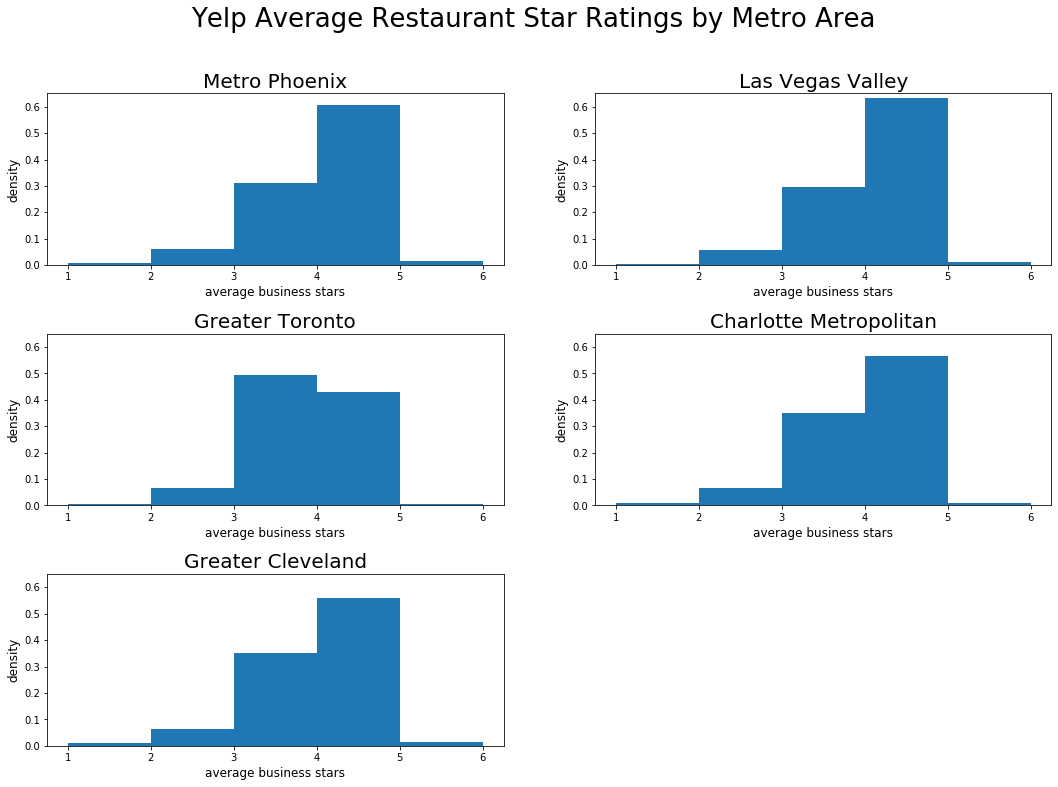

In [21]:
# Summary of average star ratings by metropolitan area
states = ['AZ', 'NV', 'ON', 'NC', 'OH']
metro = ['Metro Phoenix', 'Las Vegas Valley', 'Greater Toronto', 'Charlotte Metropolitan', 'Greater Cleveland']

fig = plt.figure(figsize=(18, 12))
for i in range(5):
    plt.subplot(3, 2, i + 1)
    plt.hist(psql_data['business_stars'][psql_data['state_'] == states[i]], bins = [1, 2, 3, 4, 5, 6], density=True)
    fig.suptitle('Yelp Average Restaurant Star Ratings by Metro Area', fontsize=26)
    plt.title(metro[i], fontsize=20)
    plt.xlabel('average business stars', fontsize=12)
    plt.ylabel('density', fontsize=12)
    plt.subplots_adjust(hspace=0.4)
    plt.ylim([0.0, 0.65])

4.23 minutes to execute code.


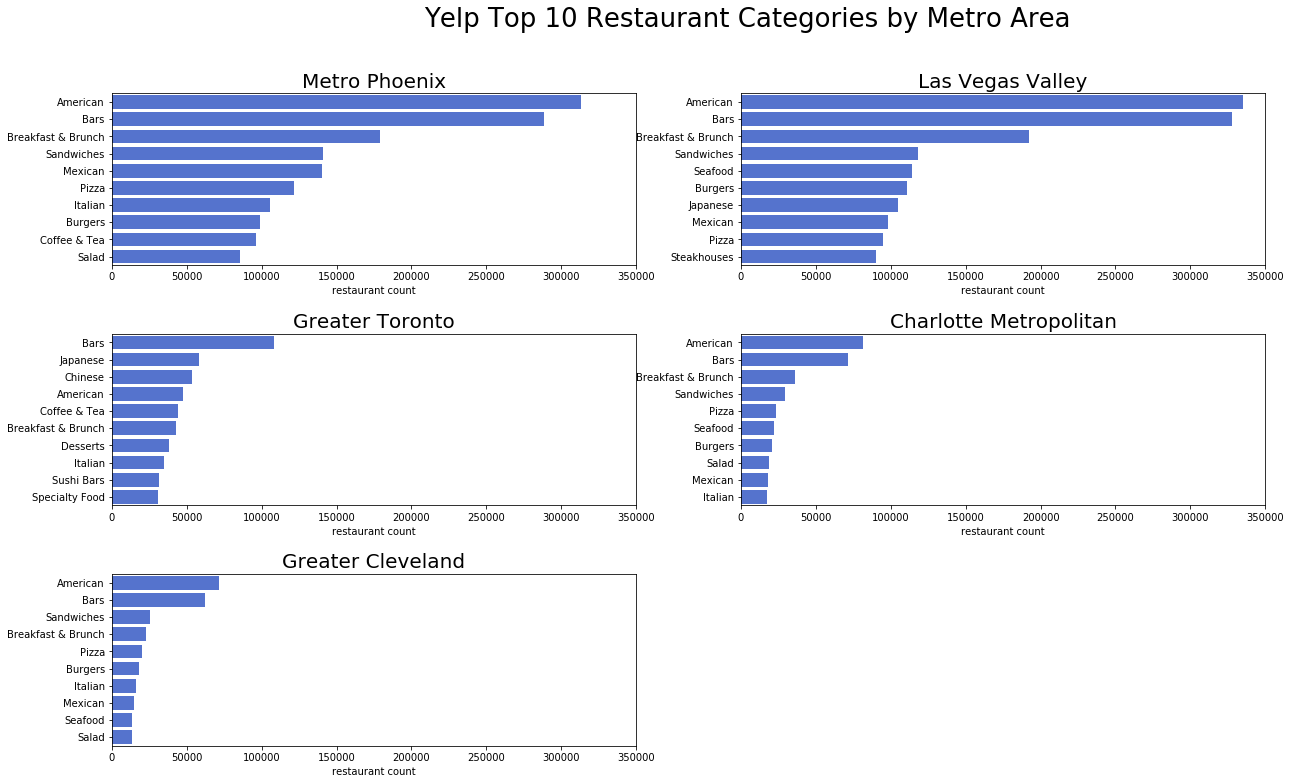

In [22]:
# Top restaurant categories by metropolitan area
t0 = time.time() 

fig = plt.figure(figsize=(18, 12))
for i in range(5):
    category_values = []
    for category in category_list:
        category_values.append(psql_data[category][psql_data['state_'] == states[i]].sum())
    category_zip = sorted(zip(category_values, category_list), reverse=True)[0:10]
    x = [a for a, _ in category_zip]
    y = [a for _, a in category_zip]
    plt.subplot(3, 2, i + 1)
    sns.barplot(x=x, y=y, label='A', color='royalblue')
    fig.suptitle('Yelp Top 10 Restaurant Categories by Metro Area', fontsize=26)
    plt.title(metro[i], fontsize=20)
    plt.xlabel('restaurant count')
    plt.subplots_adjust(left=.01, hspace=0.4)
    plt.xlim([0.0, 350000])
    
t1 = time.time()
print(round((t1 - t0)/60,2), 'minutes to execute code.')

<h3><font color='blue'>Trend in Star Ratings as Number or Reviews Increase</font></h3>
<p>The star ratings for the restaurants tend to take a dip after the first initial reviews and then increase
as the number of reviews increase. This also indicates that reviews with lower ratings tend not to have as many 
ratings.</p>

In [23]:
def ratings_moving_average(state):
    '''Average star ratings as number of reviews increases'''
    moving_average = []
    ratings = range(1, 201)
    for i in ratings:
        moving_average.append(round(psql_data['user_stars'][(psql_data['order_rank'] <= i) & 
                                                            (psql_data['review_count'] >= i) &
                                                            (psql_data['state_'] == state)].mean(),2)) 
    return ratings, moving_average

5.62 minutes to execute code.


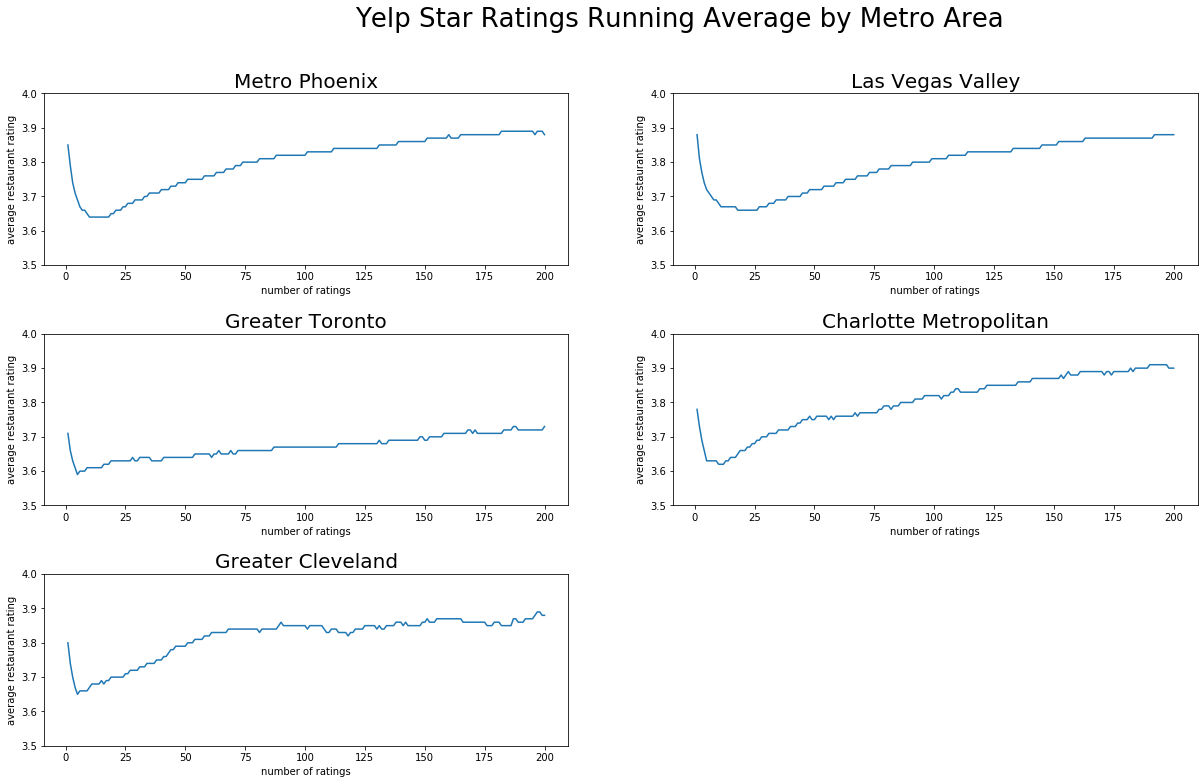

In [24]:
# Summary of star ratings as reviews increase for each metropolitan area
t0 = time.time()

fig = plt.figure(figsize=(18, 12))
for i in range(5):
    ratings, moving_average = ratings_moving_average(states[i])
    plt.subplot(3, 2, i + 1)
    sns.lineplot(x=ratings, y=moving_average)  
    fig.suptitle('Yelp Star Ratings Running Average by Metro Area', fontsize=26)
    plt.title(metro[i], fontsize=20)
    plt.xlabel('number of ratings')
    plt.ylabel('average restaurant rating')
    plt.subplots_adjust(left=.01, hspace=0.4)
    plt.ylim([3.5, 4])

t1 = time.time()
print(round((t1 - t0)/60,2), 'minutes to execute code.')

<h2>Machine Learning</h2>

<h3><font color='blue'>Limit the Number of Records to Analyze</font></h3>

In [25]:
# Limit the number of restaurant categories
selected_list = ['Italian', 'Japanese','Mexican', 'Burgers']

In [26]:
# Eliminate restaurant categories not in selected list & add counter for records with selected categories
category_list = list(psql_data.columns.values)[19:]
elimination_list = set(category_list) - set(selected_list)
psql_data = psql_data.drop(elimination_list, axis=1)
psql_data['Category_Count'] =  psql_data['Italian'] + psql_data['Japanese'] + psql_data['Mexican'] + psql_data['Burgers']

In [27]:
# Select one metropolitan area --> Metro Phoenix & chose randomly sample of 25,000 users
area = 'AZ'
users = psql_data['user_id'][psql_data['state_']==area].drop_duplicates().sample(n=25000, replace=False, random_state=40)
subset_data = psql_data[(psql_data['Category_Count'] > 0) & (psql_data['user_id'].isin(users)) & (psql_data['state_']==area)]
len(subset_data)

32288

<h3><font color='blue'>Setup Train & Test Sets</font></h3>

In [28]:
# Train, test and split
X = subset_data
y = subset_data['user_stars']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)
subset_data.head(2)

,date,review_id,user_id,user_stars,categories,business_id,business_name,review_count,business_stars,address,...,longitude,hours,is_open,friend_count,order_rank,Burgers,Italian,Japanese,Mexican,Category_Count
3200,2009-08-18 03:32:09,nByAeEziH3S7YD2_LRU4BA,5YmebJqh7Wd-g3Bh4-vvmA,4,"Food, Burgers, Restaurants, Fast Food, Ice Cre...",-_v2it0tjfDriFqN-FGpIg,Sonic Drive-In,33,3.0,15471 W Bell Rd,...,-112.392761,"{'Monday': '6:0-23:0', 'Tuesday': '6:0-23:0', ...",1,37,2,1,0,0,0,1
3214,2014-07-03 02:44:40,_tefG6MUxGDjSAUWTKhy6g,fXKLqo1D6E6liLCp5HuWkg,1,"Food, Burgers, Restaurants, Fast Food, Ice Cre...",-_v2it0tjfDriFqN-FGpIg,Sonic Drive-In,33,3.0,15471 W Bell Rd,...,-112.392761,"{'Monday': '6:0-23:0', 'Tuesday': '6:0-23:0', ...",1,1,16,1,0,0,0,1


<h3><font color='blue'>First of Three Classifiers to Evaluate - Custom Algorithm</font></h3>

In [29]:
# Create matrix for user-restaurants
def matrix(data, area, user_list):
    '''Matrix of user and restaurant star ratings'''
    matrix_restaurants = data[(data['state_']==area) & (data['user_id'].isin(user_list) & (data['review_count'] > 0))].pivot_table(index='user_id', columns='business_id', values='user_stars').fillna(0)
    return matrix_restaurants
matrix_restaurants = matrix(X_train, area, users)

In [30]:
# Sparseness of matrix
1 - (count_nonzero(np.array(matrix_restaurants))/(matrix_restaurants.shape[1] * matrix_restaurants.shape[0]))

0.9991593567225355

In [31]:
# Create similarity matrix between users
similarity = cosine_similarity(matrix_restaurants)
similarity = pd.DataFrame(similarity, index=matrix_restaurants.index, columns=matrix_restaurants.index)
similarity

user_id,--gsZ16vkDVFD5uSuUFBFw,--rms0ED1Ok7OFqZILWiAg,--xazodgk012WDgg9sOkdg,-0Jra7uIavkcu4Dh16_ouw,-0K2ZWX8tDH1mrzNXNoiqg,-0McWEfx_Kk7LGa1oxv08w,-0Wd9AHoInqLBkW7bIS4zw,-29KHRxPgoigsUO-lw1y6g,-2IvqrJdcoUTW143G3XBDg,-2_lWE1UdAIq1u9ttyTTnA,...,zv0GOvbgMLAVSHWsLJUMvQ,zv25xxIX0HblNN8sJDt19A,zv3uF3mhC2JROTWF_994Xw,zvLmXVXkbDcXWrM3D6TUwQ,zvm5CnSu8X77P5WvjeXV_g,zwazb6slpTTCLtZNsFdcJg,zxGDhtnvKYFsv0IXRUEbgQ,zyI_EO45CxVVrm-DtBXOJA,zyo_PBKqJ2nDLPnM_nR48Q,zzk6L1hPy116OGyapMhodA
user_id,,,,,,,,,,,,,,,,,,,,,
--gsZ16vkDVFD5uSuUFBFw,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--rms0ED1Ok7OFqZILWiAg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
--xazodgk012WDgg9sOkdg,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0Jra7uIavkcu4Dh16_ouw,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-0K2ZWX8tDH1mrzNXNoiqg,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwazb6slpTTCLtZNsFdcJg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
zxGDhtnvKYFsv0IXRUEbgQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
zyI_EO45CxVVrm-DtBXOJA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [32]:
# Custom weighted average algorithm
def calc_star_values(business_id, user_id):
    '''Calculations for predictions of restaurant star ratings based on weighted average methodology'''
    if user_id in list(X_train['user_id']):
        if business_id in matrix_restaurants:
            cosine_scores = similarity[user_id] # cosine similarity by user
            ratings_scores = matrix_restaurants[business_id] # star ratings for specific restaurant
            index_not_rated = ratings_scores[ratings_scores==0].index # businesses without ratings for user
            ratings_scores = ratings_scores[ratings_scores!=0] # records with ratings
            cosine_scores = cosine_scores.drop(index_not_rated) # cosine scores of only records with ratings
            if cosine_scores.sum() > 0:
                stars_prediction = np.dot(ratings_scores, cosine_scores)/cosine_scores.sum() #prediction >>> weighted average
            else:
                return -1 # -1 assigned to records without data
        else:
            return -1
    else:
        return -1
    return stars_prediction

In [33]:
# Fuction for classification report with rounding of predicted values
def precision_recall(actual_stars, predicted_stars):
    '''Round prediction values for precision recall classification report'''
    predicted_stars = [round(x) for x in predicted_stars]
    print(classification_report(actual_stars, predicted_stars)) 

In [34]:
# Find predictions using custom weighted average algorithm
predicted_ratings = []
true_ratings = []
for i in range(len(y_test)):
    if calc_star_values(X_test['business_id'].iloc[i], X_test['user_id'].iloc[i])!=-1:
        predicted_ratings.append(round(calc_star_values(X_test['business_id'].iloc[i], X_test['user_id'].iloc[i])))
        true_ratings.append(y_test.iloc[i])
predicted_ratings = np.array(predicted_ratings)
true_ratings = np.array(true_ratings)


In [35]:
# Measure results from custom weighted average algorithm
print('Weighted Average results')
precision_recall(true_ratings, predicted_ratings)

Weighted Average results
              precision    recall  f1-score   support

           1       0.27      0.08      0.13       273
           2       0.15      0.13      0.14       290
           3       0.16      0.22      0.18       467
           4       0.29      0.48      0.36       927
           5       0.51      0.28      0.36      1306

    accuracy                           0.30      3263
   macro avg       0.27      0.24      0.24      3263
weighted avg       0.34      0.30      0.30      3263



<h3><font color='blue'>Final Two of Three Classifiers to Evaluate - Surprise Library</font></h3>

In [36]:
# Set up to use python surprise library
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(subset_data[['user_id', 'business_id', 'user_stars']], reader)

In [37]:
# Train, test, split for surprise
trainset, testset = tts(data, test_size=0.25, random_state=40)

In [38]:
# Predict, fit, measure for surprise algorithms
def surprise_algo(algorithm):
    '''Model surprise algorithm using trainset and testset'''
    algo = algorithm
    predictions = algo.fit(trainset).test(testset)
    algo_df = pd.DataFrame(predictions)
    precision, recall, f1, supt = precision_recall_fscore_support(algo_df['r_ui'], round(algo_df['est']), average='weighted')
    return predictions, algo_df, precision, recall

In [39]:
# Run surprise prediction algorithms - BaselineOnly, Matrix Factorization and KNNBasic
print('BaselineOnly() results')
bl_predictions, bl_df, precision, recall = surprise_algo(BaselineOnly())
print('Precision:', precision, 'Recall:', recall, '\n')

print('Matrix Factorization SVD results')
svd_predictions, svd_df, precision, recall = surprise_algo(SVD(random_state=40))
print('Precision:', precision, 'Recall:', recall, '\n')

print('KNNBasic results')
sim_options = {'name': 'cosine','user_based': False}
knn_predictions, knn_df, precision, recall = surprise_algo(KNNBasic(sim_options=sim_options))
print('Precision:', precision, 'Recall:', recall, '\n')

BaselineOnly() results
Estimating biases using als...
Precision: 0.44282714658803124 Recall: 0.23550545094152625 

Matrix Factorization SVD results
Precision: 0.5471169296633428 Recall: 0.24801783944499503 

KNNBasic results
Computing the cosine similarity matrix...
Done computing similarity matrix.
Precision: 0.3774736572864383 Recall: 0.2651139742319128 



In [40]:
# Tune parameters for the surprise matrix factorization SVD algorithm
t0 = time.time()

factors = [3, 12, 50, 100]
epochs =[5, 10, 20, 40]
mean = [0, .05, .10, .15]
std_dev = [0, .05, .10, .15]
lr = [0.001, 0.003, 0.005,0.007]
reg = [0.01, 0.02, 0.03, 0.04]
max_precision = 0
dict = {}
for n_factors in factors:
    for n_epochs in epochs:
        for init_mean in mean:
            for init_std_dev in std_dev:
                for lr_all in lr:
                    for reg_all in reg:
                        svd_predictions, svd_df, precision, recall = surprise_algo(SVD(
                            n_factors=n_factors, n_epochs=n_epochs, init_mean=init_mean, init_std_dev=init_std_dev,
                            lr_all=lr_all, reg_all=reg_all, random_state=40))
                        if precision > max_precision:
                            max_precision = precision
                            dict = {'n_factors': n_factors, 'n_epochs': n_epochs, 'init_mean': init_mean, 'init_std_dev': init_std_dev,
                                    'lr_all': lr_all, 'reg_all': reg_all}

t1 = time.time()
print(round((t1 - t0)/60,2), 'minutes to execute code.')

289.16 minutes to execute code.


In [41]:
# Summarize the results of hyperparameter tuning
print(dict)
print(max_precision)

{'n_factors': 100, 'n_epochs': 10, 'init_mean': 0, 'init_std_dev': 0.1, 'lr_all': 0.007, 'reg_all': 0.04}
0.5590948086964709


In [42]:
# Rerun surprise matrix factorization SVD using tuned parameters
svd_predictions, svd_df, precision, recall = surprise_algo(SVD(n_factors=dict.get('n_factors'), n_epochs=dict.get('n_epochs'), 
                                                                   init_mean=dict.get('init_mean'), init_std_dev=dict.get('init_std_dev'),
                                                                   lr_all=dict.get('lr_all'), reg_all=dict.get('reg_all'), random_state=40))
print('Matrix Factorization SVD tuned results')
print('Precision:', precision)
print('Recall:', recall)    

Matrix Factorization SVD tuned results
Precision: 0.5590948086964709
Recall: 0.24194747274529238


In [43]:
# tuned matrix factorization SVD classification report
precision_recall(svd_df['r_ui'], svd_df['est'])

              precision    recall  f1-score   support

         1.0       1.00      0.00      0.00      1103
         2.0       0.20      0.01      0.01       739
         3.0       0.17      0.30      0.21       916
         4.0       0.24      0.80      0.37      1884
         5.0       0.77      0.05      0.09      3430

    accuracy                           0.24      8072
   macro avg       0.48      0.23      0.14      8072
weighted avg       0.56      0.24      0.15      8072



In [44]:
# Tuned matrix factorization SVD confusion matrix
confusion_matrix(svd_df['r_ui'], round(svd_df['est']))

array([[   2,   15,  426,  659,    1],
       [   0,    5,  251,  474,    9],
       [   0,    3,  279,  626,    8],
       [   0,    2,  348, 1504,   30],
       [   0,    0,  380, 2887,  163]], dtype=int64)

In [45]:
# Convert from multi classification to binary classification
def change_to_binary(true, predicted, threshold):
    '''Change ratings 1-5 to 0 & 1 based on specific threshold'''
    true = [1 if x >= 4 else 0 for x in true]
    predicted = [1 if x >= threshold else 0 for x in predicted]
    return true, predicted
# loop through and different thresholds in order to populate values for precision recall curve
precision_values = []
recall_values = []
for i in [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5]:
    true_values, predicted_values = change_to_binary(svd_df['r_ui'], svd_df['est'], i)
    precision, recall, f1, supt = precision_recall_fscore_support(true_values, predicted_values, average='binary')
    precision_values.append(precision)
    recall_values.append(recall)
    print('Threshold = ', i)
    print('Precision:', precision)
    print('Recall:', recall, '\n')

Threshold =  1
Precision: 0.6583250743310208
Recall: 1.0 

Threshold =  1.25
Precision: 0.6583250743310208
Recall: 1.0 

Threshold =  1.5
Precision: 0.6584882280049567
Recall: 1.0 

Threshold =  1.75
Precision: 0.6584882280049567
Recall: 1.0 

Threshold =  2
Precision: 0.6584882280049567
Recall: 1.0 

Threshold =  2.25
Precision: 0.6586091483822982
Recall: 0.9998118178396688 

Threshold =  2.5
Precision: 0.6602858918582971
Recall: 0.9996236356793377 

Threshold =  3
Precision: 0.6715384615384615
Recall: 0.9856981558148288 

Threshold =  3.25
Precision: 0.6880809185347184
Recall: 0.9473089951072639 

Threshold =  3.5
Precision: 0.7206414085835561
Recall: 0.8626270229582236 

Threshold =  3.75
Precision: 0.7752613240418118
Recall: 0.6699284907790741 

Threshold =  4
Precision: 0.8301519283209973
Recall: 0.4010161836657885 

Threshold =  4.25
Precision: 0.8783018867924528
Recall: 0.17519759126834777 

Threshold =  4.5
Precision: 0.9146919431279621
Recall: 0.03631915694392172 

Threshold =

(0, 1.05)

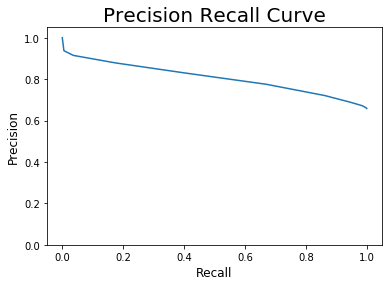

In [46]:
# Plot precision recall curve
sns.lineplot(x=recall_values, y=precision_values) 
plt.title('Precision Recall Curve', fontsize=20)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.subplots_adjust(hspace=0.4)
plt.ylim(0,1.05)

In [47]:
# Calculate area under the curve
prc_auc = auc(recall_values, precision_values)
print('Area under the precision recall curve:', prc_auc)

Area under the precision recall curve: 0.806167636666187


In [48]:
# Run algorithm for matrix factorization SVD with threshold of 3.5
true_values, predicted_values = change_to_binary(svd_df['r_ui'], svd_df['est'], 3.5)

In [49]:
# Matrix factorization SVD confusion matrix with threshold of 3.5
precision_recall(true_values, predicted_values)

              precision    recall  f1-score   support

           0       0.57      0.36      0.44      2758
           1       0.72      0.86      0.79      5314

    accuracy                           0.69      8072
   macro avg       0.65      0.61      0.61      8072
weighted avg       0.67      0.69      0.67      8072



In [50]:
# Confusion matrix for matrix factorization SVD with threshold of 3.5
confusion_matrix(true_values, predicted_values)

array([[ 981, 1777],
       [ 730, 4584]], dtype=int64)

In [51]:
# Add predicted and true value columns to DataFrame & merge to add business name and count
svd_df['true_value'] = true_values
svd_df['predicted_value'] = predicted_values
svd_df = pd.merge(svd_df, subset_data[['business_id', 'business_name']].drop_duplicates(), how='left', 
                  left_on='iid', right_on='business_id')
svd_df = pd.merge(svd_df, svd_df['uid'].value_counts(), left_on='uid', right_on=svd_df['uid'].value_counts().index)
svd_df.columns.values[10] = 'uid_count'
reco_df = svd_df[svd_df['predicted_value']==1].sort_values(by=['uid_count', 'uid', 'est'], 
                                                          ascending=[False, True, False]).drop(['details',
                                                                                                'business_id', 'uid_x'],axis=1)

In [52]:
# Recommendations
reco_df = pd.DataFrame({'user_id': reco_df['uid'], 'business_id': reco_df['iid'] , 'business_name': reco_df['business_name'], 
           'predicted_value': reco_df['predicted_value'], 'true_value': reco_df['true_value'], 'predicted_rating': reco_df['est'],
                        'true_rating': reco_df['r_ui']})
reco_df.head(10)

,user_id,business_id,business_name,predicted_value,true_value,predicted_rating,true_rating
282,iDlkZO2iILS8Jwfdy7DP9A,oMBNvB6tHlwW3UwGBYqljw,Blue Fin,1,1,4.521318,5.0
266,iDlkZO2iILS8Jwfdy7DP9A,cTZmf7B-4yciMc1WKiCVOA,Welcome Diner,1,1,4.303440,5.0
290,iDlkZO2iILS8Jwfdy7DP9A,DaVTuhzi6EgWStb2eAjNjA,Presidio Cocina Mexicana,1,1,4.170000,5.0
303,iDlkZO2iILS8Jwfdy7DP9A,Tw3miGKZHtmxmaQZIYFRrA,Federal Pizza,1,1,4.157582,5.0
288,iDlkZO2iILS8Jwfdy7DP9A,LtNgP4FqXp5nMFOHErK8cw,Yen Sushi & Sake Bar,1,1,4.039577,4.0
278,iDlkZO2iILS8Jwfdy7DP9A,qUPUCcBbn-ugXFSItXLmGw,Akai Hana Sushi & Grill,1,1,4.001893,4.0
268,iDlkZO2iILS8Jwfdy7DP9A,wa8QgXQu1ZxwPgdRl9lYlg,Tampopo Ramen,1,0,4.001597,3.0
299,iDlkZO2iILS8Jwfdy7DP9A,CUivTcULsu5MJIYYNVm1zw,Hana Japanese Eatery,1,1,3.992266,4.0
281,iDlkZO2iILS8Jwfdy7DP9A,eS29S_06lvsDW04wVrIVxg,Barrio CafÃ©,1,0,3.958837,3.0
314,iDlkZO2iILS8Jwfdy7DP9A,89uU51kOiQXbJHVA3C6XMQ,The Original Carolina's Mexican Food,1,1,3.949200,4.0
